In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons, make_circles, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
epochs = 10
lr = 0.001

In [3]:

# 데이터 준비
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)


Activation: ReLU
Final Test Accuracy: 0.8767


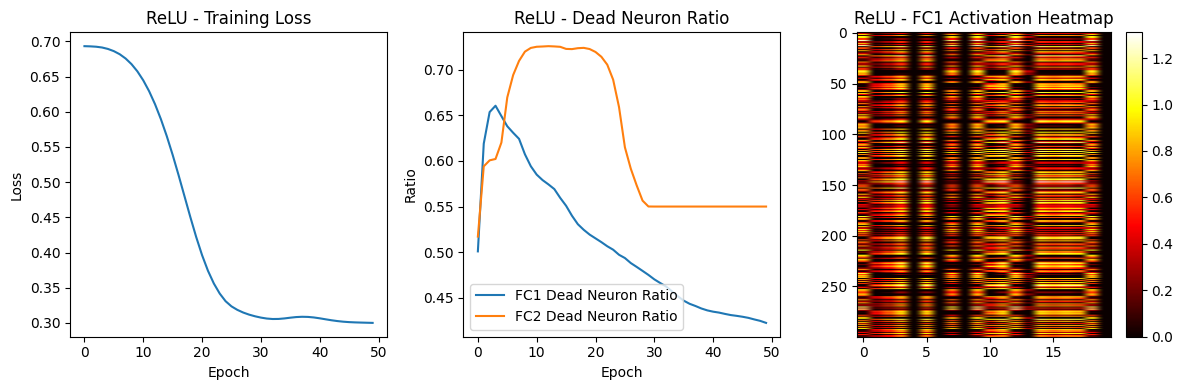

Activation: LeakyReLU
Final Test Accuracy: 0.8800


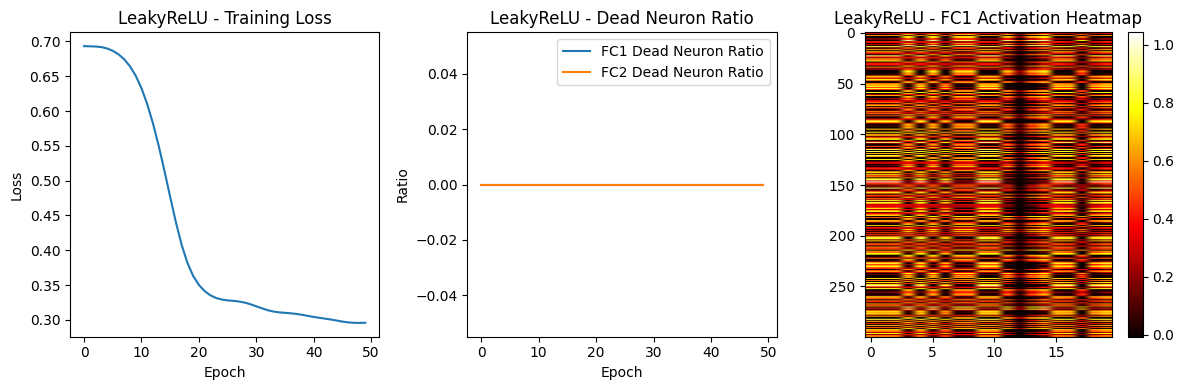

Activation: Sigmoid
Final Test Accuracy: 0.8600


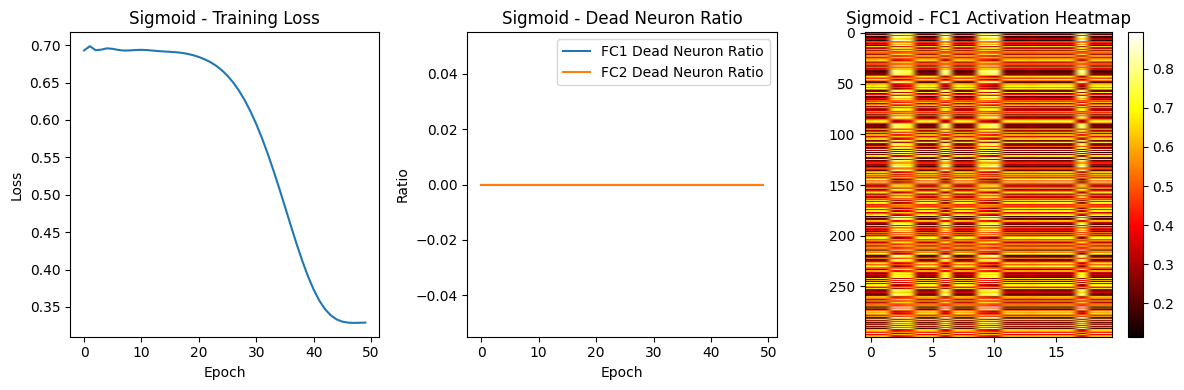

In [4]:

# 모델 정의
class SimpleNet(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 2)
        self.activation = activation
        
        # Weight 초기화 (std=0.01)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        self.out1 = self.activation(self.fc1(x))
        self.out2 = self.activation(self.fc2(self.out1))
        out = self.fc3(self.out2)
        return out

# Dead neuron 비율 계산 함수
def dead_neuron_ratio(activation_output):
    # ReLU 계열에서는 출력이 0인 neuron을 dead neuron으로 간주
    dead = (activation_output == 0).float()
    ratio = dead.mean().item()
    return ratio

# 학습 및 평가 함수
def train_and_evaluate(activation, act_name):
    print(f"Activation: {act_name}")
    model = SimpleNet(activation)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    epochs = 50
    train_losses = []
    dead_ratios_fc1 = []
    dead_ratios_fc2 = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Dead neuron 비율 측정
        model.eval()
        with torch.no_grad():
            out1 = model.out1
            out2 = model.out2
            dead_ratios_fc1.append(dead_neuron_ratio(out1))
            dead_ratios_fc2.append(dead_neuron_ratio(out2))
    
    # 최종 정확도 계산
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, preds = torch.max(test_outputs, 1)
        acc = (preds == y_test).float().mean().item()
    
    print(f"Final Test Accuracy: {acc:.4f}")
    
    # 학습 손실 그래프
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(train_losses)
    plt.title(f'{act_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Dead neuron 비율 그래프
    plt.subplot(1,3,2)
    plt.plot(dead_ratios_fc1, label='FC1 Dead Neuron Ratio')
    plt.plot(dead_ratios_fc2, label='FC2 Dead Neuron Ratio')
    plt.title(f'{act_name} - Dead Neuron Ratio')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio')
    plt.legend()
    
    # 히트맵 시각화 (마지막 epoch FC1 layer output)
    plt.subplot(1,3,3)
    plt.imshow(model.out1.detach().numpy(), aspect='auto', cmap='hot')
    plt.title(f'{act_name} - FC1 Activation Heatmap')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# ReLU, LeakyReLU, Sigmoid 실험 수행
train_and_evaluate(nn.ReLU(), 'ReLU')
train_and_evaluate(nn.LeakyReLU(0.01), 'LeakyReLU')
train_and_evaluate(nn.Sigmoid(), 'Sigmoid')